In [1]:
import os
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #omit info 
from learnMSA.msa_hmm import Configuration, Align, Visualize, Emitter, Transitioner, Initializers, Training
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset
from learnMSA.protein_language_models import Common, EmbeddingBatchGenerator

2024-10-15 11:10:08.703534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 11:10:08.717583: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 11:10:08.721716: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1728990609.894119  188611 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355



# Experimental demo: learnMSA + protein language model

This notebook demonstrates how to align a set of protein sequences with learnMSA supported by a large, pre-trained protein language model.

This configuration of learnMSA - although a prototype - is the most accurate variant of learnMSA currently available. It is also the most computationally expensive. It is recommended to run this notebook on a GPU.

In [2]:
# Your fasta file with unaligned sequences.

train_filename = "test/data/egf.fasta"

# Reference file with aligned sequences that have matching IDs to (potentially a subset of) the 
# sequences in the train_file.
# Replace with empty string if no reference is available.
ref_filename = "test/data/egf.ref"

# The number of independently trained models.
num_models = 4

HMM training supported by protein embeddings:

In [3]:
def align(filename, out_filename):
    scoring_model_config = Common.ScoringModelConfig(dim=32, lm_name="protT5", activation="softmax", scaled=False)
    config = Configuration.make_default(num_models, 
                                        use_language_model=True, 
                                        scoring_model_config=scoring_model_config,
                                        frozen_insertions=True,
                                        num_prior_components=10,
                                        V2_emitter=True,
                                        V2_temperature=3.)
    #config["batch_size"] = 16
    # we have to define a special model- and batch generator if using a language model
    # because the emission probabilities are computed differently and the LM requires specific inputs
    model_gen = EmbeddingBatchGenerator.make_generic_embedding_model_generator(config["scoring_model_config"].dim)
    batch_gen = EmbeddingBatchGenerator.EmbeddingBatchGenerator(config["scoring_model_config"])
    with SequenceDataset(train_filename, fmt="fasta") as data:
        config["crop_long_seqs"] = int(np.ceil(3 * np.mean(data.seq_lens)))
        alignment_model = Align.run_learnMSA(data,
                                            out_filename,
                                            config, 
                                            model_generator=model_gen,
                                            batch_generator=batch_gen,
                                            sequence_weights=Align.compute_sequence_weights(train_filename, "tmp", config["cluster_seq_id"]),
                                            verbose=True,
                                            align_insertions=True)
    return alignment_model

Training of 4 models on file egf.fasta
Configuration: 
{
num_models : 4
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_single=10000

/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Computing all embeddings (this may take a while).
10% done.
20% done.
30% done.
40% done.
50% done.
60% done.
70% done.
80% done.
90% done.
100% done.
Fitting models of lengths [25 22 22 26] on 7774 sequences.
Batch size= 200 Learning rate= 0.05
Using sequence weights  [1.         0.33333334 0.05882353 ... 0.05555556 0.03030303 0.25      ] .
Using 0 GPUs.


I0000 00:00:1728991558.038566  188611 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_6']. Received: the structure of inputs=*
  warnings.warn(


Epoch 1/10


/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['sequences', 'indices', 'embeddings']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(
I0000 00:00:1728991560.500144  188611 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:731: UserWarning: Gradients do not exist for variables ['emission_kernel_0', 'emission_kernel_1', 'emission_kernel_2', 'emission_kernel_3', 'transition_kernel_begin_to_match_0', 'transition_kernel_match_to_end_1', 'transition_kernel_match_to_match_2', 'transition_kernel_match_to_insert_3', 'trans

44/44 - 31s - 694ms/step - loss: 84.3504 - loglik: -7.7944e+01 - prior: -5.5804e+00 - aux_loss: 0.8261
Epoch 2/10
44/44 - 11s - 258ms/step - loss: 76.5087 - loglik: -7.2708e+01 - prior: -2.9507e+00 - aux_loss: 0.8503
Epoch 3/10
44/44 - 11s - 259ms/step - loss: 74.7462 - loglik: -7.1654e+01 - prior: -2.2276e+00 - aux_loss: 0.8648
Epoch 4/10
44/44 - 11s - 258ms/step - loss: 72.7781 - loglik: -7.0007e+01 - prior: -1.9108e+00 - aux_loss: 0.8602
Epoch 5/10
44/44 - 11s - 260ms/step - loss: 74.3269 - loglik: -7.1649e+01 - prior: -1.8152e+00 - aux_loss: 0.8624


I0000 00:00:1728991638.064462  188611 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


expansions model 0: [(12, 2), (13, 3), (14, 1), (17, 1), (19, 2)]
discards model 0: []
expansions model 1: [(10, 1), (11, 9)]
discards model 1: []
expansions model 2: [(10, 1), (11, 9)]
discards model 2: []
expansions model 3: [(12, 2), (13, 3), (16, 1), (17, 1)]
discards model 3: []
Re-initialized the encoder parameters.
Fitting models of lengths [34, 32, 32, 33] on 7774 sequences.
Batch size= 200 Learning rate= 0.05
Using sequence weights  [1.         0.33333334 0.05882353 ... 0.05555556 0.03030303 0.25      ] .
Using 0 GPUs.


I0000 00:00:1728991643.683358  188611 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_9']. Received: the structure of inputs=*
  warnings.warn(


Epoch 1/4


I0000 00:00:1728991645.854435  188611 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


44/44 - 33s - 760ms/step - loss: 68.1560 - loglik: -6.1410e+01 - prior: -5.8298e+00 - aux_loss: 0.9162
Epoch 2/4
44/44 - 14s - 321ms/step - loss: 66.4839 - loglik: -6.2560e+01 - prior: -3.0299e+00 - aux_loss: 0.8942
Epoch 3/4
44/44 - 14s - 329ms/step - loss: 65.4507 - loglik: -6.2544e+01 - prior: -2.0188e+00 - aux_loss: 0.8875
Epoch 4/4
44/44 - 14s - 316ms/step - loss: 65.3477 - loglik: -6.2904e+01 - prior: -1.5606e+00 - aux_loss: 0.8830


I0000 00:00:1728991722.964991  188611 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


expansions model 0: []
discards model 0: [12 15 26]
expansions model 1: []
discards model 1: [16]
expansions model 2: []
discards model 2: [16]
expansions model 3: []
discards model 3: [12 15]
Re-initialized the encoder parameters.
Fitting models of lengths [31, 31, 31, 31] on 7774 sequences.
Batch size= 200 Learning rate= 0.05
Using sequence weights  [1.         0.33333334 0.05882353 ... 0.05555556 0.03030303 0.25      ] .
Using 0 GPUs.


I0000 00:00:1728991729.622821  188611 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Epoch 1/4


I0000 00:00:1728991731.806261  188611 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


44/44 - 32s - 735ms/step - loss: 68.6138 - loglik: -6.2479e+01 - prior: -5.1933e+00 - aux_loss: 0.9416
Epoch 2/4
44/44 - 13s - 302ms/step - loss: 64.3673 - loglik: -6.0965e+01 - prior: -2.4658e+00 - aux_loss: 0.9367
Epoch 3/4
44/44 - 13s - 293ms/step - loss: 64.1677 - loglik: -6.1807e+01 - prior: -1.4202e+00 - aux_loss: 0.9408
Epoch 4/4
44/44 - 13s - 295ms/step - loss: 65.7084 - loglik: -6.3856e+01 - prior: -9.1533e-01 - aux_loss: 0.9372


I0000 00:00:1728991804.664479  188611 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


expansions model 0: [(0, 1)]
discards model 0: []
expansions model 1: []
discards model 1: []
expansions model 2: []
discards model 2: []
expansions model 3: []
discards model 3: []
Re-initialized the encoder parameters.
Fitting models of lengths [32, 31, 31, 31] on 7774 sequences.
Batch size= 200 Learning rate= 0.05
Using sequence weights  [1.         0.33333334 0.05882353 ... 0.05555556 0.03030303 0.25      ] .
Using 0 GPUs.


I0000 00:00:1728991811.537613  188611 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Epoch 1/20


I0000 00:00:1728991813.807892  188611 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


44/44 - 34s - 766ms/step - loss: 67.7205 - loglik: -6.1534e+01 - prior: -5.2828e+00 - aux_loss: 0.9039
Epoch 2/20
44/44 - 14s - 315ms/step - loss: 64.7835 - loglik: -6.1860e+01 - prior: -2.0111e+00 - aux_loss: 0.9122
Epoch 3/20
44/44 - 14s - 318ms/step - loss: 64.3540 - loglik: -6.2466e+01 - prior: -9.6875e-01 - aux_loss: 0.9188
Epoch 4/20
44/44 - 16s - 367ms/step - loss: 63.4428 - loglik: -6.1973e+01 - prior: -5.5480e-01 - aux_loss: 0.9147
Epoch 5/20
44/44 - 17s - 382ms/step - loss: 62.4151 - loglik: -6.1163e+01 - prior: -3.3797e-01 - aux_loss: 0.9143
Epoch 6/20
44/44 - 15s - 345ms/step - loss: 63.5885 - loglik: -6.2488e+01 - prior: -1.8737e-01 - aux_loss: 0.9133
Time for alignment: 1306.2762
Likelihoods:  ['-0.3111', '-0.3111', '-0.3111', '-0.3111']
Mean likelihood:  -0.3110819017485355
Selection criterion: AIC
Best model:  1 (0-based)


I0000 00:00:1728991935.970115  188611 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Aligning 2 insertion slices with famsa.


/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/Bio/SeqRecord.py:228: BiopythonDeprecationWarning: Using a string as the sequence is deprecated and will raise a TypeError in future. It has been converted to a Seq object.
  warnings.warn(


time for generating output: 4.1643
Wrote file test/data/interactive.alignment.fasta
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step
>l=-54.10_t=0.01
.....................$CD.......P............NP........CYN.HG..T..CS........L.....R......................A..T......G..........YTCSCL..PR......YT....GEH$..........................
>l=-57.12_t=0.01
.....................$CD.......S............QP........CRN.-G..T..CSl.......N.....T......................N..T......D..........YTCACF..PG......YT....GRY$..........................
>l=-49.07_t=0.01
.....................$CD.......S............DP........CLN.GG..T..CT........Lr....S......................L..D......S..........YSCACA..PG......YT....GQH$..........................
>l=-63.40_t=0.01
.....................$CD.......H............VT........CLN.GG..T..CQ........Lk....T......................L..E......D..........YTCACA..NG......YT....GER$..........................
>l=-64.07_t=0.01
.....................$CD.......H............VT........CLN.GG..T..CQ........Lk

I0000 00:00:1728991950.162610  188611 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728991950.350495  188611 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728991950.483108  188611 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


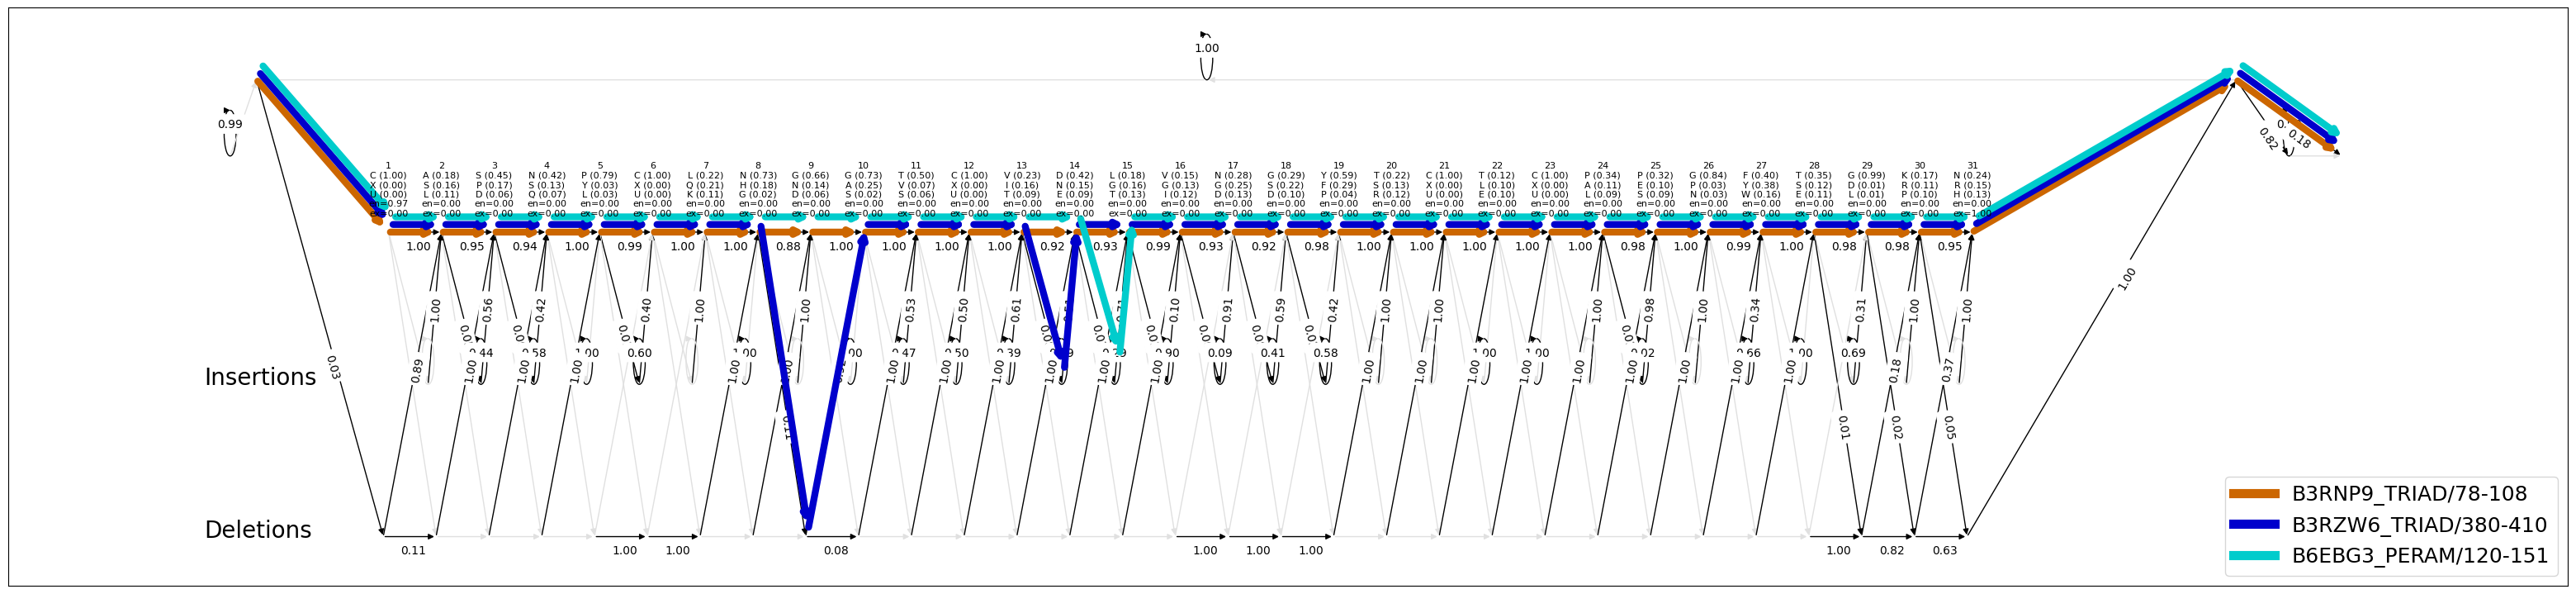

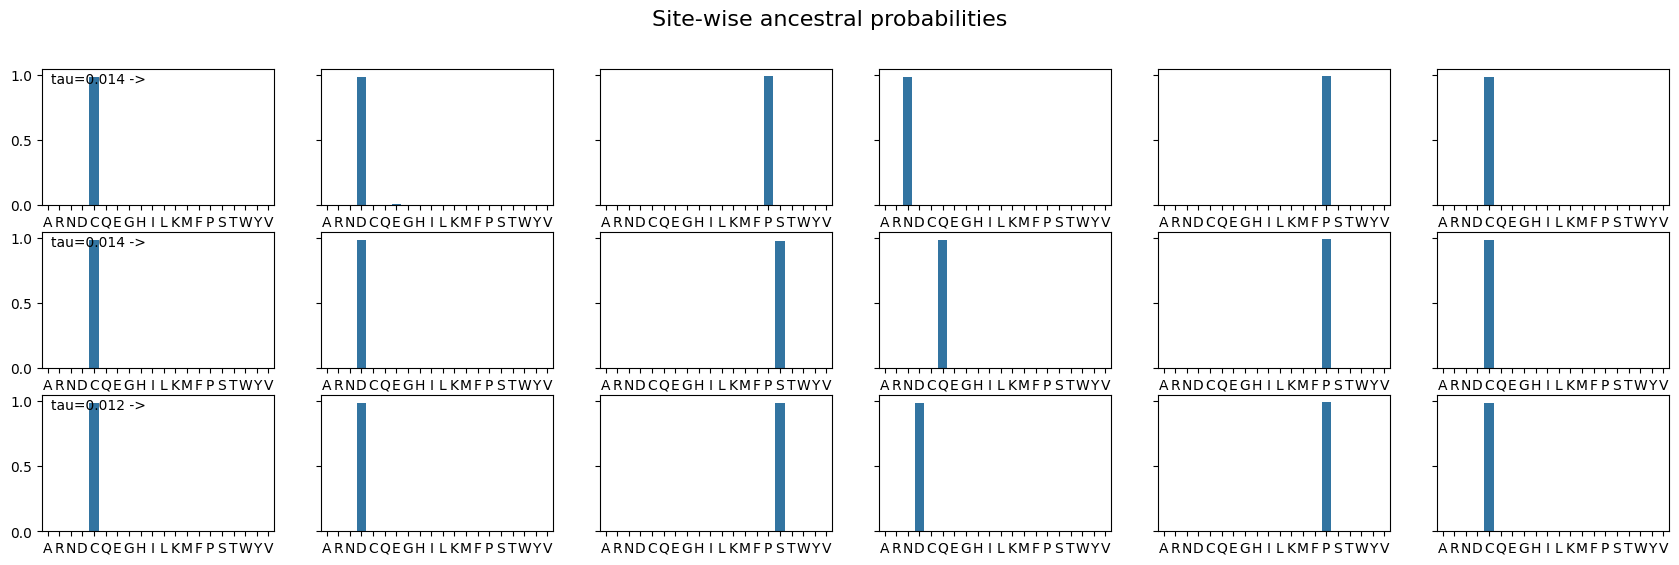

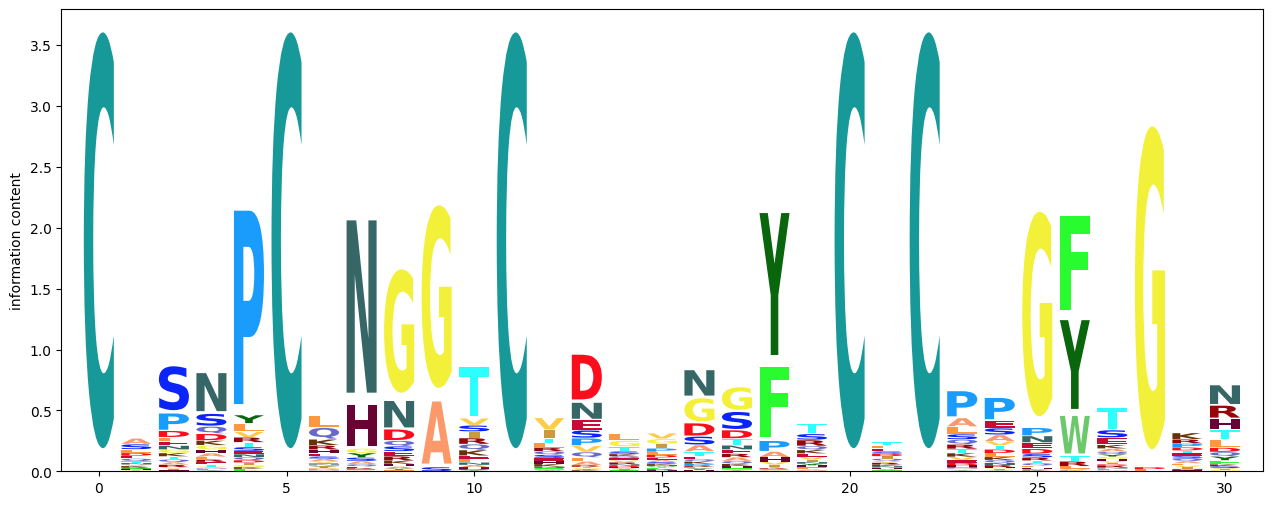

In [4]:
alignment_model = align(train_filename, "test/data/interactive.alignment.fasta") 
Visualize.print_and_plot(alignment_model, alignment_model.best_model)

In [ ]:
!id_list=$(sed -n '/^>/p' {ref_filename} | sed 's/^.//') ; export MAX_N_PID_4_TCOFFEE=10000000 ; t_coffee -other_pg seq_reformat -in test/data/interactive.alignment.fasta -action +extract_seq_list ${{id_list[@]}} +rm_gap > test/data/interactive.projection.fasta

HERE: 1tme
HERE: 2mev
HERE: 1bbt
HERE: 1r1a
HERE: 4rhv
HERE: 2plv


In [ ]:
!t_coffee -other_pg aln_compare -al1 {ref_filename} -al2 test/data/interactive.projection.fasta -compare_mode sp

*****************************************************
seq1       seq2          Sim   [ALL]           Tot  
rhv           6          33.1    67.2 [100.0]   [20998]
